<a href="https://colab.research.google.com/github/MuhaddidAlavi/Face-Detection-using-Detectron2-with-Custom-COCO-Datasets/blob/main/Face_Detection_customDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 276kB 4.5MB/s 


In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 5564 (delta 2), reused 6 (delta 2), pack-reused 5550
Receiving objects: 100% (5564/5564), 2.56 MiB | 25.00 MiB/s, done.
Resolving deltas: 100% (4007/4007), done.


In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.4
pycocotools 2.0.1
torch 1.5.0+cu101
torchvision 0.6.0+cu101
detectron2 0.1.3


In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import glob
import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS

Downloading...
From: https://drive.google.com/uc?id=1K79wJgmPTWamqb04Op2GxW0SW9oxw8KS
To: /content/face_detection.json
100% 274k/274k [00:00<00:00, 99.8MB/s]


In [ ]:
!head face_detection.json

{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e00

In [ ]:
faces_df = pd.read_json('face_detection.json', lines=True)

In [ ]:
faces_df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


In [ ]:
os.makedirs("faces", exist_ok=True)
dataset = []
for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    image_name = f'face_{index}.jpeg'
    img.save(f'faces/{image_name}', "JPEG")
    annotations = row['annotation']
    for an in annotations:
      data = {}
      width = an['imageWidth']
      height = an['imageHeight']
      points = an['points']
      data['file_name'] = image_name
      data['width'] = width
      data['height'] = height
      data["x_min"] = int(round(points[0]["x"] * width))
      data["y_min"] = int(round(points[0]["y"] * height))
      data["x_max"] = int(round(points[1]["x"] * width))
      data["y_max"] = int(round(points[1]["y"] * height))
      data['class_name'] = 'face'
      dataset.append(data)


100%|██████████| 409/409 [02:55<00:00,  2.33it/s]


In [ ]:
df = pd.DataFrame(dataset)
df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,face_0.jpeg,650,333,56,102,112,151,face
1,face_0.jpeg,650,333,379,97,428,156,face
2,face_1.jpeg,1280,697,903,162,985,252,face
3,face_2.jpeg,460,240,216,12,279,80,face
4,face_2.jpeg,460,240,289,2,343,74,face


In [ ]:
print(df.file_name.unique().shape[0], df.shape[0])

409 1132


In [ ]:
df.to_csv('annotations.csv', header=True, index=None)

In [ ]:
def annotate_image(annotations, resize=True):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'faces/{file_name}'), cv2.COLOR_BGR2RGB)
  for i, a in annotations.iterrows():
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)
  if not resize:
    return img
  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

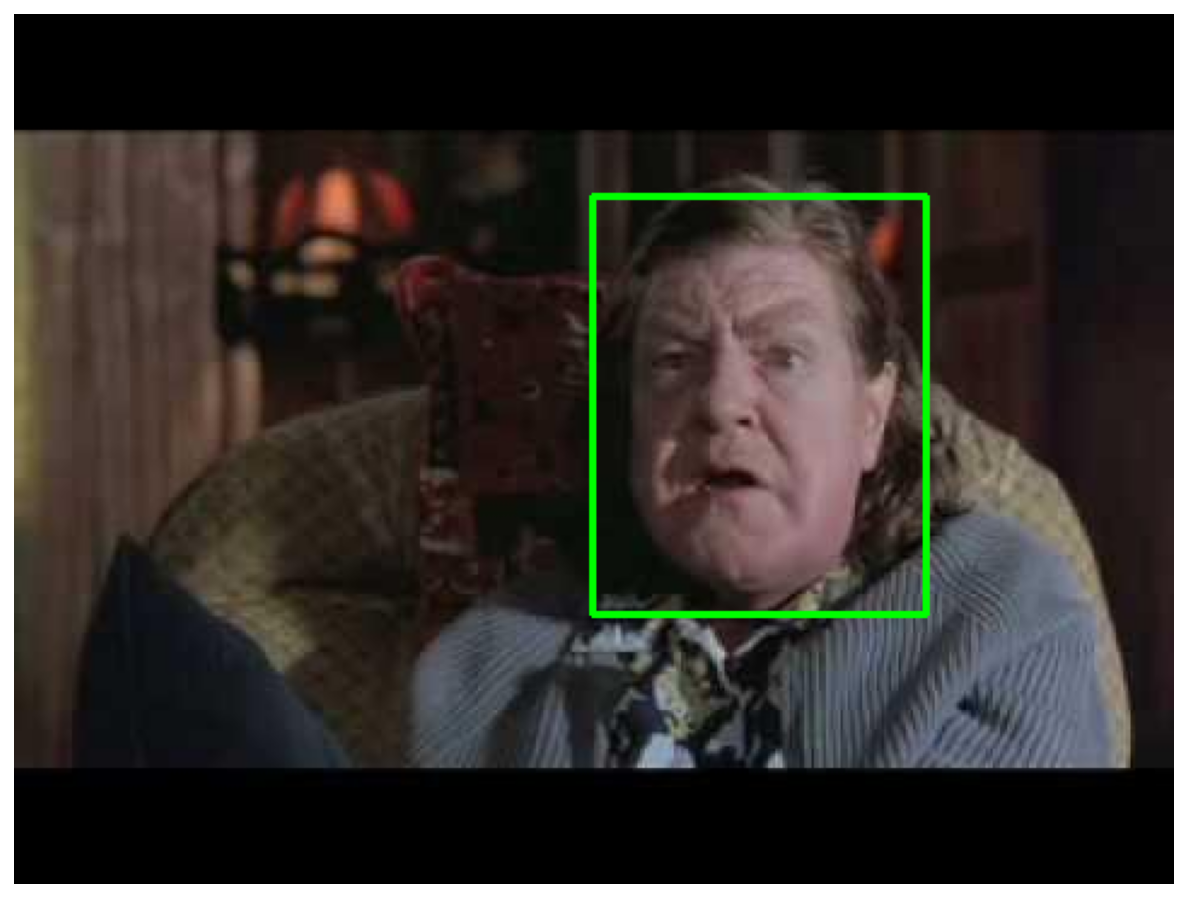

In [ ]:
img_df = df[df.file_name == df.file_name.unique()[20]]
img = annotate_image(img_df, resize=False)
plt.imshow(img)
plt.axis('off');

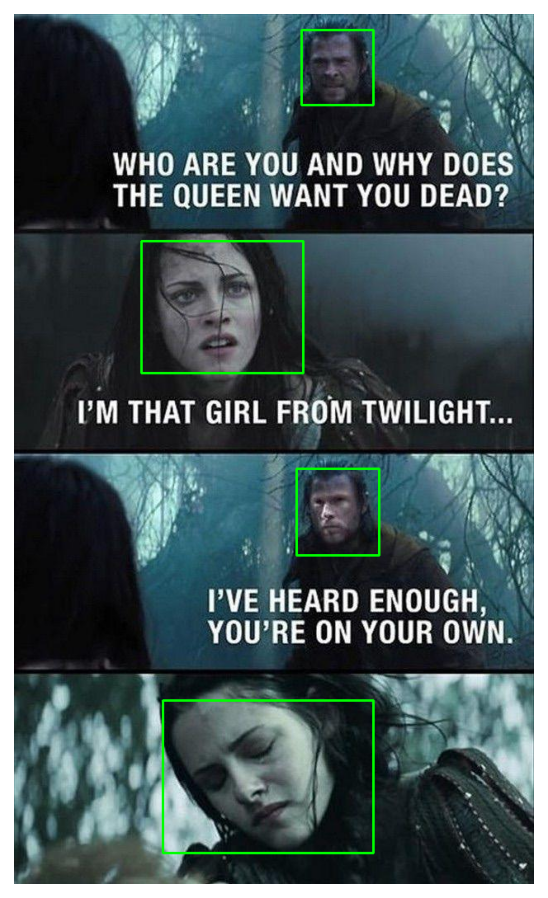

In [ ]:
img_df = df[df.file_name == df.file_name.unique()[305]]
img = annotate_image(img_df, resize=False)
plt.imshow(img)
plt.axis('off');

In [ ]:
unique_files = df.file_name.unique()
train_files = set(
    np.random.choice(unique_files,int(len(unique_files)*0.95),replace=False)
)

In [ ]:
train_files

{'face_0.jpeg',
 'face_1.jpeg',
 'face_10.jpeg',
 'face_100.jpeg',
 'face_101.jpeg',
 'face_103.jpeg',
 'face_104.jpeg',
 'face_105.jpeg',
 'face_107.jpeg',
 'face_108.jpeg',
 'face_109.jpeg',
 'face_11.jpeg',
 'face_110.jpeg',
 'face_111.jpeg',
 'face_112.jpeg',
 'face_113.jpeg',
 'face_114.jpeg',
 'face_115.jpeg',
 'face_116.jpeg',
 'face_117.jpeg',
 'face_118.jpeg',
 'face_119.jpeg',
 'face_12.jpeg',
 'face_120.jpeg',
 'face_122.jpeg',
 'face_123.jpeg',
 'face_124.jpeg',
 'face_125.jpeg',
 'face_126.jpeg',
 'face_127.jpeg',
 'face_128.jpeg',
 'face_129.jpeg',
 'face_13.jpeg',
 'face_131.jpeg',
 'face_132.jpeg',
 'face_133.jpeg',
 'face_134.jpeg',
 'face_135.jpeg',
 'face_136.jpeg',
 'face_137.jpeg',
 'face_138.jpeg',
 'face_139.jpeg',
 'face_14.jpeg',
 'face_140.jpeg',
 'face_141.jpeg',
 'face_142.jpeg',
 'face_143.jpeg',
 'face_144.jpeg',
 'face_145.jpeg',
 'face_146.jpeg',
 'face_147.jpeg',
 'face_148.jpeg',
 'face_15.jpeg',
 'face_150.jpeg',
 'face_152.jpeg',
 'face_153.jpeg',
 '

In [ ]:
len(unique_files)

409

In [ ]:
train_df = df[df.file_name.isin(train_files)]
test_df = df[-df.file_name.isin(train_files)]

In [ ]:
print(train_df.shape,test_df.shape)

(1062, 8) (70, 8)


In [ ]:
df = pd.read_csv('annotations.csv')
IMAGES_PATH = f'faces'
unique_files = df.file_name.unique()
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

In [ ]:
classes = df.class_name.unique().tolist()

In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):
    record = {}
    image_df = df[df.file_name == img_name]
    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)
    objs = []
    for _, row in image_df.iterrows():
      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)
      poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))
      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)
statement_metadata = MetadataCatalog.get("faces_train")

In [ ]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/21 01:11:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:06, 63.0MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/21 01:12:11 d2.engine.train_loop]: Starting training from iteration 0
[06/21 01:12:48 d2.utils.events]:  eta: 0:44:21  iter: 19  total_loss: 1.830  loss_cls: 0.542  loss_box_reg: 0.263  loss_mask: 0.685  loss_rpn_cls: 0.217  loss_rpn_loc: 0.024  time: 1.7870  data_time: 0.0634  lr: 0.000020  max_mem: 11282M
[06/21 01:13:24 d2.utils.events]:  eta: 0:44:14  iter: 39  total_loss: 1.753  loss_cls: 0.508  loss_box_reg: 0.399  loss_mask: 0.621  loss_rpn_cls: 0.183  loss_rpn_loc: 0.024  time: 1.8028  data_time: 0.0235  lr: 0.000040  max_mem: 11282M
[06/21 01:14:00 d2.utils.events]:  eta: 0:43:20  iter: 59  total_loss: 1.749  loss_cls: 0.473  loss_box_reg: 0.652  loss_mask: 0.530  loss_rpn_cls: 0.073  loss_rpn_loc: 0.021  time: 1.8009  data_time: 0.0232  lr: 0.000060  max_mem: 11282M
[06/21 01:14:36 d2.utils.events]:  eta: 0:42:44  iter: 79  total_loss: 1.734  loss_cls: 0.445  loss_box_reg: 0.749  loss_mask: 0.473  loss_rpn_cls: 0.055  loss_rpn_loc: 0.020  time: 1.7926  data_time: 0.0193  

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/21 02:01:40 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[06/21 02:01:40 d2.data.common]: Serialized dataset takes 0.01 MiB
[06/21 02:01:40 d2.evaluation.evaluator]: Start inference on 21 images
[06/21 02:01:43 d2.evaluation.evaluator]: Inference done 11/21. 0.2032 s / img. ETA=0:00:02
[06/21 02:01:45 d2.evaluation.evaluator]: Total inference time: 0:00:03.683098 (0.230194 s / img per device, on 1 devices)
[06/21 02:01:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.196692 s / img per device, on 1 devices)
[06/21 02:01:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/21 02:01:45 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/21 02:01:45 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE 

OrderedDict([('bbox',
              {'AP': 35.086245507683394,
               'AP50': 64.26985255578404,
               'AP75': 36.55062345435179,
               'APl': 39.27292651555733,
               'APm': 38.0661754554802,
               'APs': nan}),
             ('segm',
              {'AP': 35.50583651267193,
               'AP50': 62.98894100984458,
               'AP75': 38.54714787121915,
               'APl': 39.13068598214326,
               'APm': 39.739651412771984,
               'APs': nan})])

In [ ]:
os.makedirs("annotated_results", exist_ok=True)
test_image_paths = test_df.file_name.unique()
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata,
    scale=1.,
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

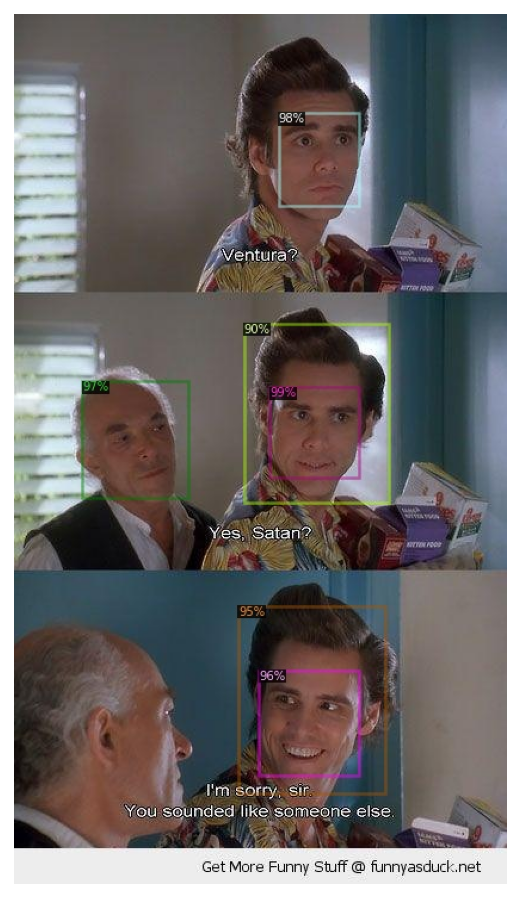

In [ ]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off');

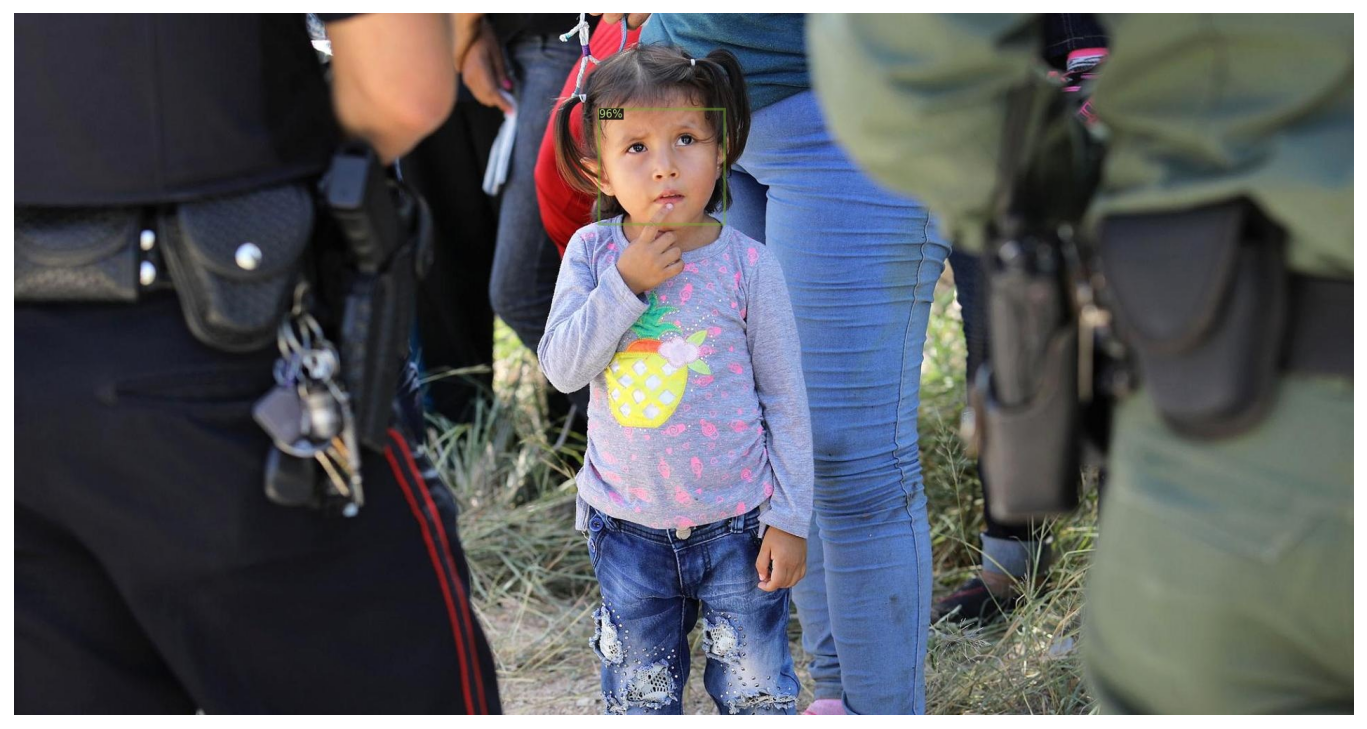

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off');